## Bitcoin price forecasting

In this notebook we use different forecasting models in order to predict the price of Bitcoin. Some of the regression models we use are:


• **ARMA** $(p,q)$: The notation ARMA $(p, q)$ refers to the model with p autoregressive terms and q moving-average terms. This model contains the AR $(p)$ and MA $(q)$ models
$$ X_t = \varepsilon_t +  \sum_{i=1}^p b_i X_{t-i} +  \sum_{i=1}^{q} c_i \varepsilon_{t-i}  $$
where $b_i,c_i$ are the paremters in the model. Finding appropriate values of $p$ and $q$ in the ARMA $(p,q)$ model can be facilitated by plotting the partial autocorrelation functions for an estimate of $p$, and likewise using the autocorrelation functions for an estimate of $q$. Extended autocorrelation functions (EACF) can be used to simultaneously determine $p$ and $q$. ARMA is limited in that it fails for non-stationary time series and does not capture seasonality.

• **ARIMA** $(p,d,q)$: Autoregressive integrated moving average. ARIMA$(p,d,q)$ where parameters $p$, $d$, and $q$ are non-negative integers, $p$ is the order (number of time lags) of the autoregressive model, $d$ is the degree of differencing (the number of times the data have had past values subtracted), and $q$ is the order of the moving-average model. \\

ARIMA(0,1,0) is simply a random walk:
$$X_t = X_{t-1}+\varepsilon_t$$ 
ARIMA(0,2,2) is given by:
$$X_t = 2X_{t-1} - X_{t-2} + (\alpha + \beta -2) \varepsilon_{t-1} + (1-\alpha) \varepsilon_{t-2} + \varepsilon_t $$


In [1]:
import yfinance as yf
from pandas_datareader import data as pdr

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

from random import randint
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

import warnings
warnings.filterwarnings("ignore")


In [2]:
#import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
yf.pdr_override() 

start_date = '2020-01-01'
end_date = '2023-12-31'
btc = pdr.get_data_yahoo(['BTC-USD'], start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
print(btc.head())

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  7194.892090  7254.330566  7174.944336  7200.174316  7200.174316   
2020-01-02  7202.551270  7212.155273  6935.270020  6985.470215  6985.470215   
2020-01-03  6984.428711  7413.715332  6914.996094  7344.884277  7344.884277   
2020-01-04  7345.375488  7427.385742  7309.514160  7410.656738  7410.656738   
2020-01-05  7410.451660  7544.497070  7400.535645  7411.317383  7411.317383   

                 Volume  
Date                     
2020-01-01  18565664997  
2020-01-02  20802083465  
2020-01-03  28111481032  
2020-01-04  18444271275  
2020-01-05  19725074095  


In [5]:
# Save historical prices into a file
btc.to_csv("btc.csv")

In [6]:
btc = pd.read_csv("btc.csv")
print(btc.head())

         Date         Open         High          Low        Close  \
0  2020-01-01  7194.892090  7254.330566  7174.944336  7200.174316   
1  2020-01-02  7202.551270  7212.155273  6935.270020  6985.470215   
2  2020-01-03  6984.428711  7413.715332  6914.996094  7344.884277   
3  2020-01-04  7345.375488  7427.385742  7309.514160  7410.656738   
4  2020-01-05  7410.451660  7544.497070  7400.535645  7411.317383   

     Adj Close       Volume  
0  7200.174316  18565664997  
1  6985.470215  20802083465  
2  7344.884277  28111481032  
3  7410.656738  18444271275  
4  7411.317383  19725074095  


In [7]:
btc.index = pd.to_datetime(btc['Date'], format='%Y-%m-%d')

In [8]:
# Remove the 'Date' column
del btc['Date']

In [9]:
btc.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095
2020-01-06,7410.452148,7781.867188,7409.292969,7769.219238,7769.219238,23276261598
2020-01-07,7768.682129,8178.215820,7768.227539,8163.692383,8163.692383,28767291327
2020-01-08,8161.935547,8396.738281,7956.774414,8079.862793,8079.862793,31672559265
2020-01-09,8082.295898,8082.295898,7842.403809,7879.071289,7879.071289,24045990466


We plot the Bitcoin prices:

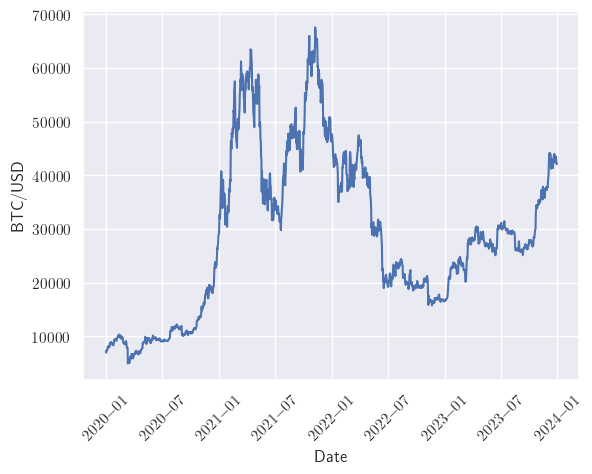

In [10]:
sns.set()
plt.ylabel('BTC/USD')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['Close'])

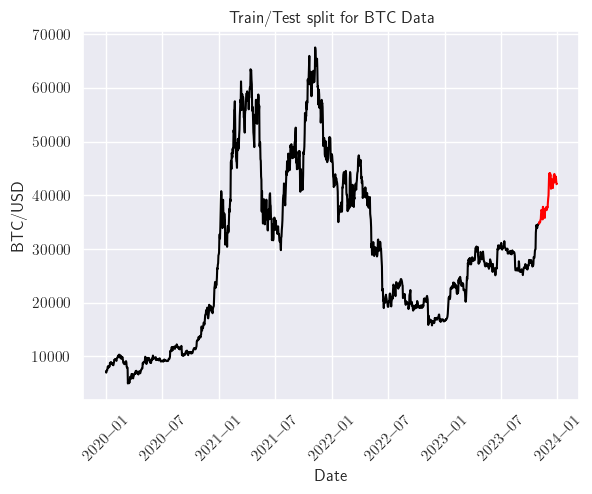

In [11]:
train = btc[btc.index < pd.to_datetime("2023-11-01", format='%Y-%m-%d')]
test = btc[btc.index > pd.to_datetime("2023-11-01", format='%Y-%m-%d')]

plt.plot(train['Close'], color = "black")
plt.plot(test['Close'], color = "red")
plt.ylabel('BTC/USD')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

In [12]:
y = train['Close']

ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47409D+00    |proj g|=  3.60628D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   1.450D-05   8.474D+00
  F =   8.4740888181352023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


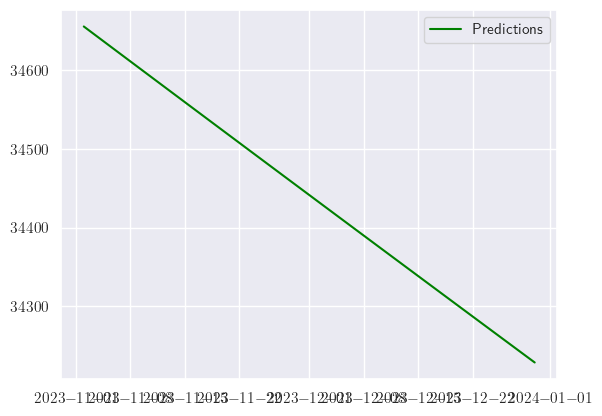

In [13]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_arma = y_pred_df["Predictions"]
plt.plot(y_pred_arma, color='green', label = 'Predictions')
plt.legend()

In [14]:
arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  6168.664540961568


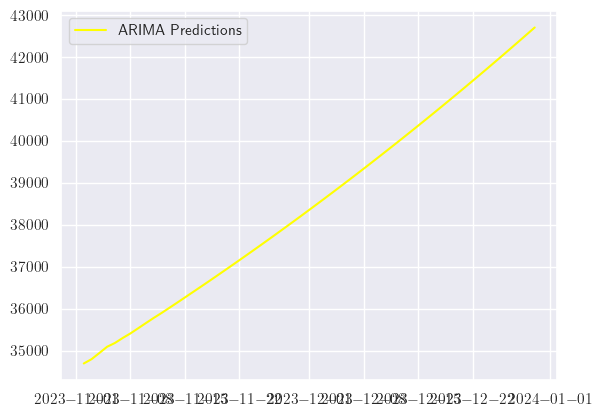

In [15]:
ARIMAmodel = ARIMA(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_arima = y_pred_df["Predictions"] 
plt.plot(y_pred_arima, color='Yellow', label = 'ARIMA Predictions')
plt.legend()


In [16]:
arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  1900.6315395319987


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78397D+00    |proj g|=  8.35666D-01

At iterate    5    f=  9.23865D+00    |proj g|=  1.25836D-02

At iterate   10    f=  9.22681D+00    |proj g|=  1.58483D-03

At iterate   15    f=  9.22660D+00    |proj g|=  1.47315D-03

At iterate   20    f=  9.22642D+00    |proj g|=  8.41258D-04

At iterate   25    f=  9.22571D+00    |proj g|=  1.90958D-02

At iterate   30    f=  9.21756D+00    |proj g|=  2.45029D-02

At iterate   35    f=  9.20655D+00    |proj g|=  8.90095D-03

At iterate   40    f=  9.20091D+00    |proj g|=  3.98608D-03

At iterate   45    f=  9.19999D+00    |proj g|=  4.74680D-03

At iterate   50    f=  9.19969D+00    |proj g|=  5.58303D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number

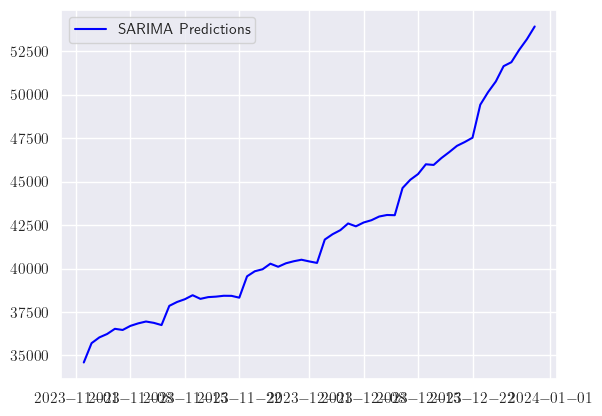

In [17]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,4,10))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_sarima = y_pred_df["Predictions"] 
plt.plot(y_pred_sarima, color='Blue', label = 'SARIMA Predictions')
plt.legend()

In [18]:
arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("SARIMA RMSE: ",arma_rmse)

SARIMA RMSE:  3868.232223570082


Final plot with the predictions from the different models:

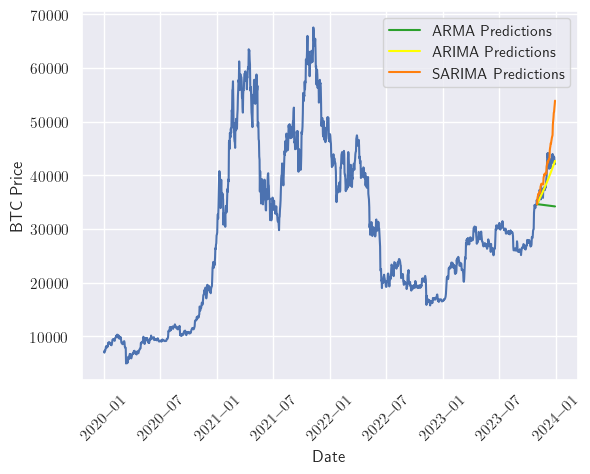

In [19]:
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['Close'], )
plt.plot(y_pred_arma, color='tab:green', label = 'ARMA Predictions')
plt.plot(y_pred_arima, color='yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_sarima, color='tab:orange', label = 'SARIMA Predictions')
plt.legend()